In [ ]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

In [32]:
import time

In [6]:
!unzip Mental-Health-Twitter.csv.zip

Archive:  Mental-Health-Twitter.csv.zip
  inflating: Mental-Health-Twitter.csv  


In [7]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = "cpu"


In [8]:
df = pd.read_csv("Mental-Health-Twitter.csv")

In [9]:
df.head()

,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,It’s hard to say whether packing lists are mak...,1013187241,84,211,251,837,1,1


In [10]:
#We have two classes
df['label'].value_counts()

1    10000
0    10000
Name: label, dtype: int64

In [11]:
df = df[["post_text","label"]]

In [12]:
from sklearn.preprocessing import LabelEncoder
df["label"] = LabelEncoder().fit_transform(df['label'])
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,post_text,label
0,It's just over 2 years since I was diagnosed w...,1
1,"It's Sunday, I need a break, so I'm planning t...",1
2,Awake but tired. I need to sleep but my brain ...,1
3,RT @SewHQ: #Retro bears make perfect gifts and...,1
4,It’s hard to say whether packing lists are mak...,1


In [13]:
X = df.post_text.values.tolist()
y = df.label.values.tolist()

In [14]:
#Splitting the datasets
train_text, temp_text, train_labels, temp_labels = train_test_split(X, y, 
                                                                    random_state=20, 
                                                                    test_size=0.2, 
                                                                    )

# Using temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=20, 
                                                                test_size=0.1, 
                                                                )

In [15]:
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [16]:
# Importing BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


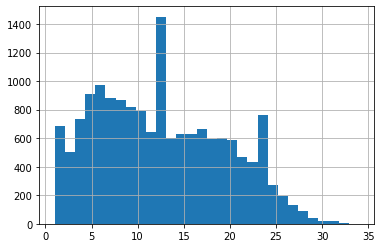

In [17]:
# Getting length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [18]:
max_seq_len = 25

# Tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [19]:
# Converting Integer Sequences to Tensor

# For train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels)

# For validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels)

# For test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels)

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Define a batch size
batch_size = 32

# Wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# Sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# Sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# DataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [21]:
# Freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [22]:
# Model Architecture

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      # Dropout layer
      self.dropout = nn.Dropout(0.1)
      # Relu activation function
      self.relu =  nn.ReLU()
      # Dense layer 1
      self.fc1 = nn.Linear(768,512)
      # Dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)
      # Softmax activation function
      self.softmax= nn.LogSoftmax(dim=1)


    # Define the forward pass
    def forward(self, sent_id, mask):
      # Pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      # Output layer
      x = self.fc2(x)
      x = self.softmax(x)
      return x

In [23]:
model = BERT_Arch(bert)
# Use GPU if available
model = model.to(device)
print(device)

from transformers import AdamW, get_linear_schedule_with_warmup
#OPtimizer for the trasnformer
optimizer = AdamW(model.parameters(),lr=1e-3)

cuda


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [24]:
#Find the class weights
from sklearn.utils.class_weight import compute_class_weight
class_wts = compute_class_weight('balanced',classes=np.unique(train_labels),y=train_labels)
print(class_wts)

[1.00075056 0.99925056]


In [25]:
#Convert class weights to tensor
weights = torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)
#Loss function
cross_entropy = nn.NLLLoss(weight=weights)
#Number of epochs
epochs = 10

In [26]:
# Function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save model predictions
  total_preds=[]
  
  # Iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # Progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # Push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # Clear previously calculated gradients 
    model.zero_grad()        

    # Get model predictions for the current batch
    preds = model(sent_id, mask)

    # Compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # Add on to the total loss
    total_loss = total_loss + loss.item()

    # Backward pass to calculate the gradients
    loss.backward()

    # Clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # Append the model predictions
    total_preds.append(preds)

  # Compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # Predictions are in the form of (no. of batches, size of batch, no. of classes).
  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  # Returns the loss and predictions
  return avg_loss, total_preds

In [35]:
import datetime
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [40]:
# Function for evaluating the model
def evaluate():
  
  #t0 = time.time()
  print("\nEvaluating...")
  
  # Deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # Empty list to save the model predictions
  total_preds = []

  # Iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # Push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # Deactivate autograd
    with torch.no_grad():
      
      # Model predictions
      preds = model(sent_id, mask)

      # Compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # Compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # Reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [41]:
# Set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

t0 = time.time()
# For each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # Train model
    train_loss, _ = train()
    
    # Evaluate model
    valid_loss, _ = evaluate()
    
    # Save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    500.
  Batch   100  of    500.
  Batch   150  of    500.
  Batch   200  of    500.
  Batch   250  of    500.
  Batch   300  of    500.
  Batch   350  of    500.
  Batch   400  of    500.
  Batch   450  of    500.

Evaluating...
  Batch    50  of    113.
  Batch   100  of    113.

Training Loss: 0.600
Validation Loss: 0.556

 Epoch 2 / 10
  Batch    50  of    500.
  Batch   100  of    500.
  Batch   150  of    500.
  Batch   200  of    500.
  Batch   250  of    500.
  Batch   300  of    500.
  Batch   350  of    500.
  Batch   400  of    500.
  Batch   450  of    500.

Evaluating...
  Batch    50  of    113.
  Batch   100  of    113.

Training Loss: 0.584
Validation Loss: 0.544

 Epoch 3 / 10
  Batch    50  of    500.
  Batch   100  of    500.
  Batch   150  of    500.
  Batch   200  of    500.
  Batch   250  of    500.
  Batch   300  of    500.
  Batch   350  of    500.
  Batch   400  of    500.
  Batch   450  of    500.

Evaluating...
  Batch    50 

In [42]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [43]:
# Get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [44]:
# Model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.65      0.69      0.67       190
           1       0.71      0.66      0.68       210

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400



In [45]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test_y, preds)

#Printing per class accuracy
print (100*matrix.diagonal()/matrix.sum(axis=1))

[69.47368421 66.19047619]


In [48]:
df.columns

Index(['post_text', 'label'], dtype='object')

### Test on sample data

In [53]:
text = df.loc[5:10,'post_text']

In [55]:
text = text.to_list()

In [51]:
tokenizer2 = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [56]:
max_seq_len = 25
tokens_text = tokenizer2.batch_encode_plus(
    text,
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [57]:
text_seq = torch.tensor(tokens_text['input_ids'])
text_mask = torch.tensor(tokens_text['attention_mask'])

In [59]:
with torch.no_grad():
  preds = model(text_seq.to(device), text_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [61]:
preds = np.argmax(preds, axis = 1)
preds

array([1, 1, 1, 1, 0, 1])

In [62]:
text

['Making packing lists is my new hobby... #movinghouse',
 'At what point does keeping stuff for nostalgic reasons cross the line into plain old hoarding...? #movinghouse',
 'Currently in the finding-boxes-of-random-shit packing phase. I think I’m a closet hoarder...',
 "Can't be bothered to cook, take away on the way 😁👍🏼 #lazy",
 'RT @itventsnews: ITV releases promo video for the final series of Downton Abbey http://t.co/mC8Ive72zR http://t.co/CFBKrRvJIs',
 '... also, I have too much stuff. Way, way too much #movinghouse']

In [82]:
tokenizer.save_pretrained("Health_Psychology_Analysis/tokenizer/")

('Health_Psychology_Analysis/tokenizer/tokenizer_config.json',
 'Health_Psychology_Analysis/tokenizer/special_tokens_map.json',
 'Health_Psychology_Analysis/tokenizer/vocab.txt',
 'Health_Psychology_Analysis/tokenizer/added_tokens.json',
 'Health_Psychology_Analysis/tokenizer/tokenizer.json')

In [83]:
torch.save(model.state_dict(), 'Health_Psychology_Analysis/saved_weights.pt')

In [65]:
#To load the tokenizer
#tokenizer3 = BertTokenizerFast.from_pretrained('models/tokenizer/')